# Learning TensorFlow - Day 4 - MNIST for experts

We now follow https://www.tensorflow.org/get_started/mnist/pros.

In [1]:
import tensorflow as tf

In [2]:
# shape is the shape of the output tensor (for example, (3, 2) for a 3x2 matrix).

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)  # values from a normal but not further than 2 stddev
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [3]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

## First Convolutional Layer

In [4]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

In [5]:
x = tf.placeholder(dtype=tf.float32, shape=[None, 784])
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [6]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

## Second Convolutional Layer

In [7]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

## Densely Connected Layer

All the neurons from the previous layer will be now connected to the 1024 neurons of this layer (that has no structure).

In [8]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

## Dropout

Used to reduce overfitting.

In [9]:
keep_prob = tf.placeholder(dtype=tf.float32)  # on during training, off during testing
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## Readout Layer

In [10]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

## Train and Evaluate

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

y_ = tf.placeholder(dtype=tf.float32, shape=[None, 10])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [12]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 50
N_TRAINING = 1000

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

steps = []
accuracies = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(N_TRAINING):
        batch = mnist.train.next_batch(BATCH_SIZE)
        if i % 20 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0],
                                                      y_: batch[1], keep_prob: 1.0})
            steps.append(i)
            accuracies.append(train_accuracy)
        
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print('Test accuracy: %g' % accuracy.eval(feed_dict={x: mnist.test.images,
                                                         y_: mnist.test.labels, keep_prob: 1.0}))

Test accuracy: 0.9616


We could play with the values of `LEARNING_RATE`, `BATCH_SIZE` and `N_TRAINING`, in addition to changing the number of neurons in each layer, or the kernels used for the convolution, or the number of layers.

**Note (Jordi)**: why does it have `keep_prob: 0.5` in the training step? (and not `keep_prob: 0`).

### Results

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


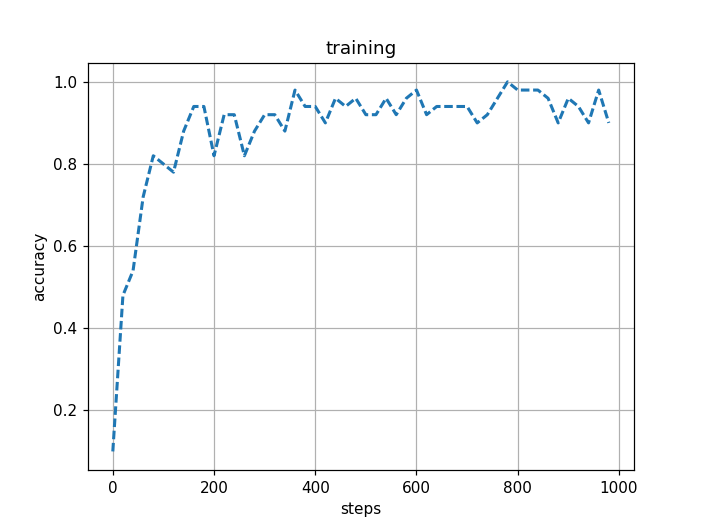

In [14]:
plt.plot(steps, accuracies, '--', linewidth=2)
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.title('training')
plt.grid(True)